In [227]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, GRU, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import os
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [228]:
sequences = np.load('sequences_pose.npy')
labels = np.load('labels_pose.npy')
actions = np.array(['goodbye', 'hi', 'you', 'me', 'thankyou', 'goodmorning'])

In [229]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [230]:
# X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3)

# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

X_train = np.load('data/train.npy')
y_train = np.load('data/labels_train.npy')
X_valid = np.load('data/validation.npy')
y_valid = np.load('data/labels_validation.npy')
X_test = np.load('data/test.npy')
y_test = np.load('data/labels_test.npy')

In [332]:
np.save('data/train.npy',X_train)
np.save('data/validation.npy',X_valid)
np.save('data/test.npy',X_test)
np.save('data/labels_train.npy',y_train)
np.save('data/labels_validation.npy',y_valid)
np.save('data/labels_test.npy',y_test)

In [460]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
callback = EarlyStopping(monitor='loss', patience=3, start_from_epoch = 30)

In [457]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 258)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(30, 258)))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(256, dropout=0.2)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [458]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [485]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback,callback])

Epoch 1/100
15/15 [==============================] - 3s 171ms/step - loss: 0.2316 - categorical_accuracy: 0.8839
Epoch 2/100
15/15 [==============================] - 2s 147ms/step - loss: 0.2283 - categorical_accuracy: 0.9011
Epoch 3/100
15/15 [==============================] - 2s 150ms/step - loss: 0.2077 - categorical_accuracy: 0.9075
Epoch 4/100
15/15 [==============================] - 2s 159ms/step - loss: 0.2813 - categorical_accuracy: 0.8817
Epoch 5/100
15/15 [==============================] - 3s 187ms/step - loss: 0.4311 - categorical_accuracy: 0.8323
Epoch 6/100
15/15 [==============================] - 2s 158ms/step - loss: 0.3712 - categorical_accuracy: 0.8409
Epoch 7/100
15/15 [==============================] - 3s 159ms/step - loss: 0.2414 - categorical_accuracy: 0.8946
Epoch 8/100
15/15 [==============================] - 2s 159ms/step - loss: 0.2331 - categorical_accuracy: 0.8774
Epoch 9/100
11/15 [=====================>........] - ETA: 0s - loss: 0.2842 - categorical_accura

KeyboardInterrupt: 

In [426]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 28, 128)           99200     
                                                                 
 conv1d_45 (Conv1D)          (None, 26, 128)           49280     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 8, 128)           0         
 g1D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 8, 128)            0         
                                                                 
 conv1d_46 (Conv1D)          (None, 6, 256)            98560     
                                                                 
 conv1d_47 (Conv1D)          (None, 4, 256)            196864    
                                                     

In [247]:
# model.load_weights('action.h5')

In [486]:
res = model.predict(X_valid)

4/4 [==============================] - 0s 23ms/step


In [487]:
actions[np.argmax(res[60])]

'me'

In [488]:
actions[np.argmax(y_valid[60])]

'thankyou'

In [445]:
model.save('action3.h5')

In [489]:
yhat = model.predict(X_valid)

4/4 [==============================] - 0s 45ms/step


In [490]:
ytrue = np.argmax(y_valid, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [491]:
cm = confusion_matrix(ytrue,yhat)

In [492]:
cm_df = pd.DataFrame(cm,
                     index = ['goodbye', 'hi', 'you', 'me', 'thankyou', 'goodmorning'], 
                     columns = ['goodbye', 'hi', 'you', 'me', 'thankyou', 'goodmorning'])

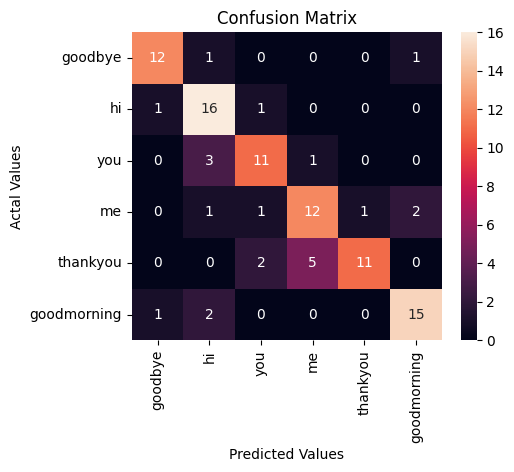

In [493]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [494]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[84,  2],
        [ 2, 12]],

       [[75,  7],
        [ 2, 16]],

       [[81,  4],
        [ 4, 11]],

       [[77,  6],
        [ 5, 12]],

       [[81,  1],
        [ 7, 11]],

       [[79,  3],
        [ 3, 15]]])

In [495]:
accuracy_score(ytrue, yhat)

0.77

In [496]:
recall_score(ytrue, yhat, average = 'weighted')

0.77

In [497]:
precision_score(ytrue, yhat, average = 'weighted')

0.783550724637681

In [498]:
f1_score(ytrue, yhat, average = 'weighted')

0.7690592334494774